In [1]:
import pandas as pd
import os
import json
import joblib
import platform
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map
from tqdm_joblib import tqdm_joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, log_loss, roc_auc_score
import socceraction.spadl as spadl
import numpy as np
from sklearn.metrics import make_scorer
import xgboost as xgb

In [2]:
# Import functions
from src.data_processing import config_h5_file_paths, fetch_match_data, generate_match_data, split_games, split_match_data, adjust_results, load_match_data

In [3]:
# 1. Lade den Datensatz
spadl_h5 = ".\\xSuccess\\top5_15-16_spadl\\match_data.h5"

with pd.HDFStore(spadl_h5) as spadlstore:
    # Spiele laden
    games = spadlstore["games"]
    
    # Du kannst auch teams / players laden, wenn du sie für später brauchst
    teams = spadlstore["teams"]
    players = spadlstore["players"]
    
    all_actions_list = []
    
    # Über alle Spiele iterieren
    for gid in games.game_id:
        df_actions = spadlstore[f"actions/game_{gid}"]
        # Ggf. noch die 'game_id' explizit als Spalte hinzufügen,
        # falls du sie später brauchst.
        df_actions["game_id"] = gid
        
        all_actions_list.append(df_actions)
    
    # Zu einem großen DataFrame zusammenfügen
    all_actions = pd.concat(all_actions_list, ignore_index=True)

#all_actions["game_id"].count()

In [4]:
all_actions = (
    all_actions
    .merge(spadl.actiontypes_df(), how='left', on='type_id')
    .merge(spadl.results_df(), how='left', on='result_id')
    .merge(spadl.bodyparts_df(), how='left', on='bodypart_id')
)

Länge der Aktion bestimmen

In [5]:
# 3) Die Länge der Dribblings bestimmen (euklidische Distanz zwischen Start- und Endkoordinate)

all_actions["action_distance"] = np.sqrt(
    (all_actions["end_x"] - all_actions["start_x"])**2 +
    (all_actions["end_y"] - all_actions["start_y"])**2
)

Winkel für Schüsse zum Tor bestimmen\
0 Grad = Zentral vor dem Tor\
Negativer Winkel = links vom Tor\
Positiver Winkel = rechts vom Tor

In [6]:
# Angenommen: Spielfeld geht von x=0 bis x=105 (Opta Standard)
def detect_goal_side(end_x, field_length=105):
    return 'left' if end_x < field_length / 2 else 'right'

def calculate_centered_shot_angle(row):
    # Ziel-Torposition
    if row['goal_side'] == 'right':
        goal_x, goal_y = 105, 34
        dx = goal_x - row['start_x']
    else:
        goal_x, goal_y = 0, 34
        dx = row['start_x'] - goal_x  # Richtung umdrehen!

    dy = goal_y - row['start_y']

    # Jetzt ist dx immer positiv → Richtung zum Tor ist einheitlich
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

In [7]:
all_actions['shot_angle_centered'] = np.nan

In [8]:
# Torseite erkennen (für alle Zeilen, nicht nur Schüsse)
all_actions['goal_side'] = all_actions['start_x'].apply(detect_goal_side)

In [9]:
# Winkel nur für Schüsse berechnen
shot_mask = all_actions['type_name'] == 'shot'
all_actions.loc[shot_mask, 'shot_angle_centered'] = all_actions[shot_mask].apply(calculate_centered_shot_angle, axis=1)

Nach jeder Aktion wird die Distanz zum Tor berechnet

In [10]:
# Berechnung der Distanz zum Tor. Hier wird für jede Zeile abhängig von der goal_side der entsprechende Tor-X-Wert gewählt.
all_actions["distance_to_goal"] = np.sqrt(
    (all_actions["end_x"] - np.where(all_actions["goal_side"] == "right", 105, 0))**2 +
    (all_actions["end_y"] - 34)**2
)

Result_id umwandeln, sodass nur fail oder success vorhanden ist

In [11]:
all_actions["result_id"] = np.where(all_actions["result_id"] == 1, 1, 0)

Jeder NaN Wert wird mit 999 gefüllt

In [12]:
all_actions.fillna(999, inplace=True)

Es wird eine Unique_id erstellt, da es keine eindeutige ID für jede Aktion gibt. \
originale_event_id kommt doppelt vor, da Socceraction bei abgefangen Pässen den Pass und das Abfangen als zwei Aktionen aber einem Event definieren.

In [13]:
all_actions["unique_id"] = all_actions["game_id"].astype(str) + "_" + all_actions["action_id"].astype(str)
all_actions.sort_values(by="unique_id", ascending=True, inplace=True)

Datensatz aufteilen in Train und Test

In [14]:
# Split games
train_games, test_games, validation_games = split_games(
  games=all_actions,
  train_percentage=50,
  random_state=42,
  shuffle=True
)

In [15]:
test_games.shape

(1819929, 22)

Features und Zielvariable auswählen

In [16]:
#features = ["start_x", "start_y", "end_x", "end_y", "bodypart_id", "type_id", "action_distance",'shot_angle_centered', "time_seconds",'distance_to_goal']
features = ["start_x", "start_y", "bodypart_id", "type_id", "action_distance", "time_seconds",'distance_to_goal','shot_angle_centered']
target = "result_id"


X_train = train_games[features]
Y_train = train_games[target]

In [17]:
X_test = test_games[features]
Y_test = test_games[target]

Modell erstellen, falls noch keines vorliegt

In [18]:
# Modellpfad
model_path = "xgb_model.json"

# Überprüfen, ob das Modell existiert
if os.path.exists(model_path):
    print("Lade vorhandenes Modell...")
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(model_path)
else:
    print("Kein gespeichertes Modell gefunden. Trainiere neues Modell...")

    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train, Y_train)

    # Speichere das Modell
    xgb_model.save_model("xgb_model.json")
    print("Neues Modell gespeichert als:", model_path)

Lade vorhandenes Modell...


Genauigkeit und Brier-Score bestimmen um festzustellen ob die neuen Parameter besser sind als das aktuelle Modell

In [19]:
print(X_test.isnull().sum())


start_x                0
start_y                0
bodypart_id            0
type_id                0
action_distance        0
time_seconds           0
distance_to_goal       0
shot_angle_centered    0
dtype: int64


In [20]:
print(X_test[X_test.isnull().any(axis=1)])


Empty DataFrame
Columns: [start_x, start_y, bodypart_id, type_id, action_distance, time_seconds, distance_to_goal, shot_angle_centered]
Index: []


In [21]:
def evaluate_model(model, X, y):
    y_pred = model.predict_proba(X)[:, 1]
    # Brier Score: misst die durchschnittliche quadratische Differenz zwischen 
    # den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen binären Ergebnissen.
    brier = brier_score_loss(y, y_pred)
    print(f"Brier score: {brier:.5f}")

    # Log Loss: misst, wie gut die Wahrscheinlichkeiten die tatsächlichen Ergebnisse repräsentieren.
    ll = log_loss(y, y_pred)
    print(f"log loss score: {ll:.5f}")

    # ROC AUC: misst die Fähigkeit des Modells, zwischen Klassen zu unterscheiden (0 vs. 1).
    roc_auc = roc_auc_score(y, y_pred)
    print(f"ROC AUC: {roc_auc:.5f}")

In [22]:
evaluate_model(xgb_model, X_test, Y_test)

Brier score: 0.07059
log loss score: 0.22205
ROC AUC: 0.93734


Erst RandomSearch um den Suchraum zu beschränken. anschließend Gridsearch um die parameter zu verfeinern, da gridsearch zeitintensiv ist

RandomSearch Paramter

In [23]:
param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 8),
    'subsample': np.linspace(0.6, 1.0, 5)
}

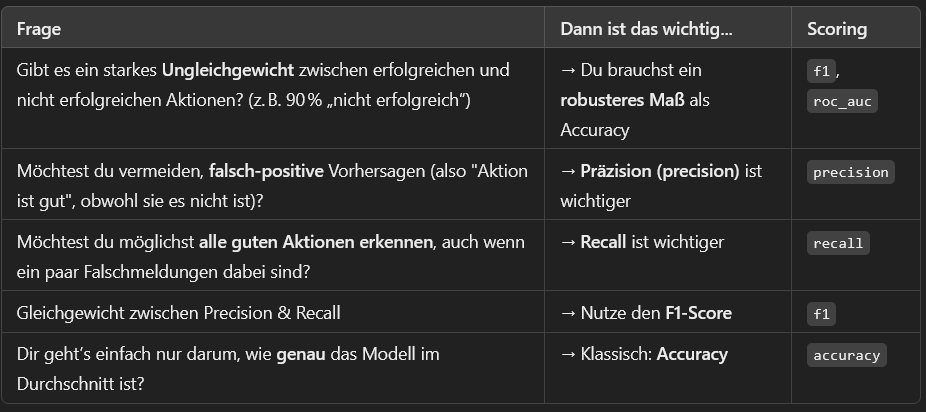

Scoring = Accuracy macht kein sinn, da die verteilung sehr unausgeglichen ist. somit würde das modell nur lernen immer "1" vorher zu sagen.\
Es wird stattdessen f1 scoring ausgewählt, da möglichst viele gute Aktionen korrekt erkennen, aber auch schlechte Aktionen nicht ignorieren\
F1 = Standardempfehlung bei Imbalance (harmonischer Mittelwert aus Precision & Recall)

In [24]:
# 3. RandomizedSearchCV starten
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_brier_score',  # Negativer Brier Score: besser = höherer (weniger negative) Wert
    #scoring='f1', # Brier Score möglich?
    cv=2,
    n_jobs=-1,
    random_state=42
)

# Ladebalken aktivieren während der Suche
with tqdm_joblib(tqdm(desc="RandomizedSearchCV läuft", total=20)):
    random_search.fit(X_train, Y_train)


print("Beste Parameter:", random_search.best_params_)

RandomizedSearchCV läuft:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Beste Parameter: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.11555555555555555}


In [ ]:
# 4. Top 3 Ergebnisse extrahieren
results = pd.DataFrame(random_search.cv_results_)
top3 = results.sort_values(by='mean_test_score', ascending=False).head(3)

In [ ]:
# 5. Parameterranges aus den Top 3 automatisch generieren
def get_unique_nearby_values(series, padding=1):
    values = sorted(series.unique())
    if all(isinstance(v, int) for v in values):
        return list(set([v - padding for v in values] + values + [v + padding for v in values]))
    else:
        return sorted(series.unique())

In [ ]:
n_estimators_vals = get_unique_nearby_values(top3['param_n_estimators'], padding=25)
learning_rate_vals = get_unique_nearby_values(top3['param_learning_rate'], padding=0.01)
max_depth_vals = get_unique_nearby_values(top3['param_max_depth'], padding=1)
subsample_vals = get_unique_nearby_values(top3['param_subsample'], padding=0.05)

In [ ]:
# 6. Neues Grid für GridSearchCV
param_grid = {
    'n_estimators': sorted(set(n_estimators_vals)),
    'learning_rate': sorted(set(learning_rate_vals)),
    'max_depth': sorted(set(max_depth_vals)),
    'subsample': sorted(set(subsample_vals)),
}

In [ ]:

print("Verfeinertes Parameter-Grid für GridSearchCV:")
for k, v in param_grid.items():
    print(f"{k}: {v}")

In [ ]:
# 7. GridSearchCV zur Feinabstimmung
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_brier_score',
    cv=2,
    n_jobs=-1
)

In [ ]:
os.cpu_count()

In [ ]:
grid_search.fit(X_train, Y_train)

bei 1232 Minuten abgebrochen\



In [ ]:
# 8. Beste Parameter anzeigen
print("Beste Parameter nach GridSearchCV:")
print(grid_search.best_params_)

In [ ]:

# 9. Bestes Modell speichern
best_model = grid_search.best_estimator_
model_path = "best_gb_model.pkl"
joblib.dump(best_model, model_path)
print(f"Bestes Modell wurde gespeichert als: {model_path}")

In [ ]:
#gb_model_loaded = joblib.load("best_gb_model.pkl")

# Beste Parameter holen
best_random_params = random_search.best_params_

# Umwandlung in normale Python-Typen
best_random_params_serializable = {key: float(value) if isinstance(value, (np.float32, np.float64)) 
                            else int(value) if isinstance(value, (np.int32, np.int64)) 
                            else value 
                            for key, value in best_random_params.items()}

# In JSON speichern
with open("beste_random_parameter.json", "w") as f:
    json.dump(best_random_params_serializable, f, indent=4)

print("Beste Parameter wurden in 'beste_random_parameter.json' gespeichert.")

In [ ]:

# Shutdown-Befehl für Windows
if platform.system() == "Windows":
    print("Notebook fertig. PC wird in 60 Sekunden heruntergefahren...")
    os.system("shutdown /s /t 60")  # 60 Sekunden Verzögerung (zum Abbrechen)
else:
    print("Nicht-Windows-System erkannt. Kein Shutdown durchgeführt.")